# 322 Project Exploratory Data Analysis

In [382]:
import importlib
import random

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.plot_utils 
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plotutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

In [383]:
customerData = MyPyTable()
customerData.load_from_file('projectData/test.csv')
customerData.remove_rows_with_missing_values()

# get rid of # and ID columns
newTable = []
for row in customerData.data:
    newTable.append(row[2:])
customerData.data = newTable
customerData.column_names = customerData.column_names[2:]


## Random Subsampling

In [384]:
indices = list(range(len(customerData.data)))
random.shuffle(indices)
subset = indices[0:5000]
newTable = []
for ind in subset:
    newTable.append(customerData.data[ind])
customerData.data = newTable

satisfaction = []
for row in customerData.data:
    satisfaction.append(row.pop())



## Categorizing Flight Distance

Splitting flight distance into five equal width bins, then placing each distance in a category 1-5.

In [385]:
distance = myutils.get_column(customerData.data, customerData.column_names, 'Flight Distance')
distCutoffs = myutils.compute_equal_width_cutoffs(distance, 5)
distBins = myutils.convert_cutoffs_to_bins(distCutoffs)
for i in range(len(customerData.data)):
    customerData.data[i][5] = myutils.convertBinToCategory(customerData.data[i][5], distBins)

## Categorizing Age

Splitting age into five equal width bins, then placing each age in a category 1-5.

In [386]:
age = myutils.get_column(customerData.data, customerData.column_names, 'Age')
ageCutoffs = myutils.compute_equal_width_cutoffs(age, 5)
ageBins = myutils.convert_cutoffs_to_bins(ageCutoffs)
for i in range(len(customerData.data)):
    customerData.data[i][2] = myutils.convertBinToCategory(customerData.data[i][2], ageBins)

# Exploratory Data Analysis

## Overall Satisfaction

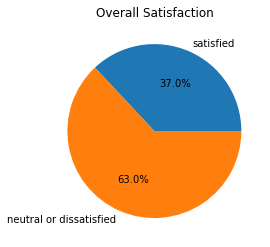

In [387]:
totSatisfied = 0

for val in satisfaction:
    if val == 'satisfied':
        totSatisfied += 1
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [totSatisfied, len(satisfaction) - totSatisfied], 'Overall Satisfaction')

## Gender and Customer Satisfaction

In [388]:
genders = myutils.get_column(customerData.data, customerData.column_names, 'Gender')

totalMale = 0
totalFemale = 0
maleCount = 0
femaleCount = 0

for i in range(len(customerData.data)):
    if customerData.data[i][0] == 'Male':
        totalMale += 1
        if satisfaction[i] == 'satisfied':
            maleCount += 1
    if customerData.data[i][0] == 'Female':
        totalFemale += 1
        if satisfaction[i] == 'satisfied':
            femaleCount += 1

### Gender Distribution

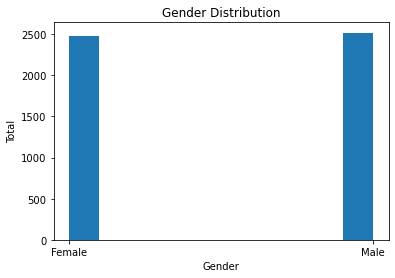

In [389]:
plotutils.plot_histogram(genders, 'Gender Distribution', 'Gender', 'Total')

### Male Flight Satisfaction

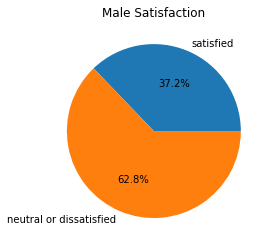

In [390]:
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [maleCount, totalMale - maleCount], 'Male Satisfaction')


### Female Flight Satisfaction

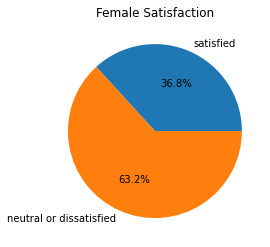

In [391]:
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [femaleCount, totalFemale - femaleCount], 'Female Satisfaction')

There is a seemingly even distribution of males and females in the dataset, and they both have similar levels of satisfaction.

## Airplane Class and Satisfaction

In [392]:
classes = myutils.get_column(customerData.data, customerData.column_names, 'Class')

totalEco = 0
totalEcoPlus = 0
totalBusiness = 0
ecoCount = 0
plusCount = 0
businessCount = 0

for i in range(len(customerData.data)):
    if customerData.data[i][4] == 'Eco':
        totalEco+= 1
        if satisfaction[i] == 'satisfied':
            ecoCount += 1
    if customerData.data[i][4] == 'Eco Plus':
        totalEcoPlus+= 1
        if satisfaction[i] == 'satisfied':
            plusCount += 1
    if customerData.data[i][4] == 'Business':
        totalBusiness += 1
        if satisfaction[i] == 'satisfied':
            businessCount += 1

## Economy Satisfaction

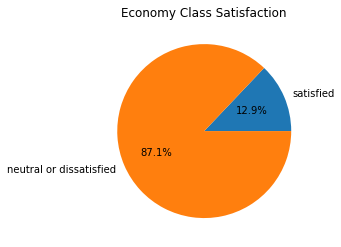

In [393]:
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [ecoCount, totalEco - ecoCount], 'Economy Class Satisfaction')

## Economy Plus Satisfaction

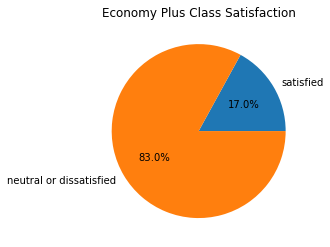

In [394]:
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [plusCount, totalEcoPlus - plusCount], 'Economy Plus Class Satisfaction')

## Business Satisfaction

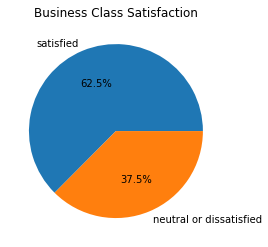

In [395]:
plotutils.plot_pie_chart(['satisfied', 'neutral or dissatisfied'], [businessCount, totalBusiness - businessCount], 'Business Class Satisfaction')

We can see the overwhelming majority of customers flying in economy and economy plus fall into the neutral or dissatisfied class, while the majority of business class customers were satisfied with their flight. This may give us some insight to how heavily the 'Class' attribute will affect our classifiers.

In [396]:
k = 10

xTrainInd, xTestInd = myevaluation.stratified_kfold_cross_validation(customerData.data, satisfaction, k)
#print(xTestInd)


allStratAccuracies = []
for i in range(k):
    xTrain = []
    yTrain = []
    xTest = []
    yTest = []

    satTree = MyDecisionTreeClassifier()

    for val in xTrainInd[i]:
        xTrain.append(customerData.data[val])
        yTrain.append(satisfaction[val])
    for val in xTestInd[i]:
        xTest.append(customerData.data[val])
        yTest.append(satisfaction[val])
    satTree.fit(xTrain, yTrain)
    #print(satTree.print_decision_rules())
    #print(satTree.tree)
    predictions = satTree.predict(xTest)
    
    count = 0

    for i in range(len(predictions)):
        if predictions[i] == yTest[i]:
            count += 1
    accuracy = count / len(predictions)
    allStratAccuracies.append(accuracy)
   
stratKFoldAcc = round(sum(allStratAccuracies) / len(allStratAccuracies), 3)
print(stratKFoldAcc)
    


0.931
